In [55]:
import json
import pandas as pd
import numpy as np

import os
import datetime
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, InputLayer, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import glorot_normal, RandomNormal, Zeros

import math
from keras.datasets import cifar10, cifar100
from scipy.cluster.vq import whiten

import glob
import os

from keras.applications import InceptionV3, Xception, InceptionResNetV2
from keras import Model

from ann_visualizer.visualize import ann_viz

from keras.utils.vis_utils import plot_model

%matplotlib inline

# Neural network test

In [39]:
def format_data(x_train, x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = x_train/255.
    x_test = x_test/255.
    return x_train, x_test

In [40]:
def normalize_data(x_train, x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = normalize_production(x_train)
    x_test = normalize_production(x_test)
    return x_train,x_test

Does Whitening work when it is done independently on x_train and x_test? (e.g., should the same whitening factor be used on x_test as on x_train)

In [41]:
def whiten_data(x_train, x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    X = np.append(x_train, x_test, axis=0)
    X_white = whiten(X).reshape(X.shape)
    x_train_white = X_white[0:x_train.shape[0]]
    x_test_white = X_white[x_train.shape[0]:x_train.shape[0]+x_test.shape[0]]
    return x_train_white, x_test_white

In [42]:
# from VGG model 

def normalize_production(x):
    #this function is used to normalize instances in production according to saved training set statistics
    # Input: X - a training set
    # Output X - a normalized training set according to normalization constants.

    #these values produced during first training and are general for the standard cifar10 training set normalization
    mean = 120.707
    std = 64.15
    return (x-mean)/(std+1e-7)

In [43]:
def create_output_files (x_train, x_test, y_train, y_test, prefix, suffix = ""):
    for model_ind, model in enumerate(models):
        pred_train = model.predict(x_train)
        pred_test = model.predict(x_test)
        pred_train_with_target = np.array([np.array([preds, y_train[i]]) for i,preds in enumerate(pred_train)])
        pred_test_with_target = np.array([np.array([preds, y_test[i]]) for i,preds in enumerate(pred_test)])
        path = input_path + "Intermediate/" + prefix + "/" + model_names[model_ind]
        if not os.path.exists(path):
            os.makedirs(path)
        np.save(path + "/train" + suffix, pred_train_with_target)
        np.save(path + "/test" + suffix, pred_test_with_target)

In [44]:
def dev_pipeline(class_start, class_end, prefix):
    final_images, batches,curr_labels = fetch_data_from_classes(input_path + "images", img_rows, img_cols, classes = list(range(class_start,class_end)))
    x_train, x_test, y_train, y_test = train_test_split(batches, curr_labels, test_size=0.25)
    x_train, x_test = format_data(x_train, x_test)
    classes_to_retain = range(class_start,class_end)
    num_classes = len(classes_to_retain)
    x_train, y_train = filter_for_classes(x_train, y_train, classes_to_retain)
    x_test, y_test = filter_for_classes(x_test,y_test,classes_to_retain)
    x_train, x_test = whiten_data(x_train,x_test)
    y_train_categorical = to_categorical(y_train)
    y_test_categorical = to_categorical(y_test)
    suffix = "_{}-{}".format(class_start, class_end)
    create_output_files(x_train, x_test, y_train, y_test, prefix, suffix)

In [45]:
def run_all(prefix, class_chunk_size=10, label_file = "351_Data\ILSVRC2012_Validation\labels\ILSVRC2012_devkit_t12\data\ILSVRC2012_validation_ground_truth.txt"):
    labels = np.array(pd.read_csv(label_file, header=None, names=["Class"]))
    num_classes = len(np.unique(labels))
    start_ind = min (np.unique(labels))
    # path = input_path + "Intermediate\\" + prefix + "\\" + model_names[model_ind]
    # if not os.path.exists(path):
    #    os.makedirs(path)

    while True:
        dev_pipeline(start_ind, start_ind + class_chunk_size, prefix)
        if start_ind+ class_chunk_size>max(np.unique(labels)):
            dev_pipeline(start_ind, max(np.unique(labels)) + 1, prefix)
            break
        start_ind = start_ind + class_chunk_size    

In [46]:
def imsave(fname, arr, vmin=None, vmax=None, cmap=None, format=None, origin=None):
    from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
    from matplotlib.figure import Figure

    fig = Figure(figsize=arr.shape[::-1], dpi=1, frameon=False)
    canvas = FigureCanvas(fig)
    fig.figimage(arr, cmap=cmap, vmin=vmin, vmax=vmax, origin=origin)
    fig.savefig(fname, dpi=1, format=format)

In [47]:
def show_image_classes(images, classes, prefix, suffix=""):
    for cl in np.unique(y_train):
        for ind,el in enumerate(y_train):
            if el == cl:
                class_pos = ind
                break
        plt.figure()
        plt.imshow(np.uint8(x_train[class_pos]))
        path = "353_Sample_Images/" + prefix + "/"
        if not os.path.exists(path):
            os.makedirs(path)
        plt.savefig(path + input_path.split("/")[1].split("_")[0] + "_" + str(cl) + "_sample_image_" + suffix)

In [48]:
def create_MLP_1(input_shape):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), padding='same',
            input_shape=x_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('elu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [49]:
def create_MLP_2(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

In [50]:
# SimpleNet benchmark from https://github.com/EricAlcaide/SimpleNet-Keras/blob/master/simplenet.py

def create_simple_net(input_shape):

    act = 'relu'
    s = 2
    weight_decay = 1e-2

    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3,3), padding='same', kernel_initializer=glorot_normal(), input_shape=x_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))

    # Block 2
    model.add(Conv2D(128, (3,3), padding='same', kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))

    # Block 3
    model.add(Conv2D(128, (3,3), padding='same', kernel_initializer=RandomNormal(stddev=0.01)))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))

    # Block 4
    model.add(Conv2D(128, (3,3), padding='same', kernel_initializer=RandomNormal(stddev=0.01)))
    model.add(BatchNormalization())
    model.add(Activation(act))
    # First Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=s))
    model.add(Dropout(0.2))


    # Block 5
    model.add(Conv2D(128, (3,3), padding='same', kernel_initializer=RandomNormal(stddev=0.01)))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))

    # Block 6
    model.add(Conv2D(128, (3,3), padding='same', kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))

    # Block 7
    model.add(Conv2D(256, (3,3), padding='same', kernel_initializer=glorot_normal()))
    # Second Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=s))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))


    # Block 8
    model.add(Conv2D(256, (3,3), padding='same', kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))

    # Block 9
    model.add(Conv2D(256, (3,3), padding='same', kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    # Third Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=s))


    # Block 10
    model.add(Conv2D(512, (3,3), padding='same', kernel_initializer=glorot_normal()))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))

    # Block 11  
    model.add(Conv2D(2048, (1,1), padding='same', kernel_initializer=glorot_normal()))
    model.add(Activation(act))
    model.add(Dropout(0.2))

    # Block 12  
    model.add(Conv2D(256, (1,1), padding='same', kernel_initializer=glorot_normal()))
    model.add(Activation(act))
    # Fourth Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=s))
    model.add(Dropout(0.2))


    # Block 13
    model.add(Conv2D(256, (3,3), padding='same', kernel_initializer=glorot_normal()))
    model.add(Activation(act))
    # Fifth Maxpooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=s))

    # Final Classifier
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [51]:
# from https://github.com/geifmany/cifar-vgg
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers

class cifar10vgg:
    def __init__(self,train=True):
        self.num_classes = 10
        self.weight_decay = 0.0005
        self.x_shape = [32,32,3]

        self.model = self.build_model()
        if train:
            self.model = self.train(self.model)
        else:
            self.model.load_weights('351_Data/CIFAR10_filtered/Benchmark_Models/Data/cifar10vgg.h5')


    def build_model(self):
        # Build the network of vgg for 10 classes with massive dropout and weight decay as described in the paper.

        model = Sequential()
        weight_decay = self.weight_decay

        model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=self.x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

        model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))


        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))
        return model


    def normalize(self,X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

    def normalize_production(self,x):
        #this function is used to normalize instances in production according to saved training set statistics
        # Input: X - a training set
        # Output X - a normalized training set according to normalization constants.

        #these values produced during first training and are general for the standard cifar10 training set normalization
        mean = 120.707
        std = 64.15
        return (x-mean)/(std+1e-7)

    def predict(self,x,normalize=True,batch_size=50):
        if normalize:
            x = self.normalize_production(x)
        return self.model.predict(x,batch_size)

    def train(self,model):

        #training parameters
        batch_size = 128
        maxepoches = 250
        learning_rate = 0.1
        lr_decay = 1e-6
        lr_drop = 20
        # The data, shuffled and split between train and test sets:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train, x_test = self.normalize(x_train, x_test)

        y_train = keras.utils.to_categorical(y_train, self.num_classes)
        y_test = keras.utils.to_categorical(y_test, self.num_classes)

        def lr_scheduler(epoch):
            return learning_rate * (0.5 ** (epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

        #data augmentation
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)



        #optimization details
        sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])


        # training process in a for loop with learning rate drop every 25 epoches.

        historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=maxepoches,
                            validation_data=(x_test, y_test),callbacks=[reduce_lr],verbose=2)
        model.save_weights('cifar10vgg.h5')
        return model

In [52]:
def cut_model (input_model):
    dense_layer_count = 0
    count = False
    model_length = len(input_model.layers)
    output_model = Sequential()
    output_config = []
    for index in range(model_length):
      if (count == True):
          output_config.append(layer.get_config())
          input_model.pop()
      else: layer = input_model.layers[index]
      if layer.name.startswith('flatten'):
          count = True
          output_model.add(InputLayer(input_shape=layer.output_shape))          
    # return output_model

In [53]:
def plot_model_stats(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Model Definition

I will start by "randomly" creating models.

everything from class_start till class_end is included in the data (excluding class_end)

In [1]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

NameError: name 'cifar100' is not defined

In [ ]:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [57]:
input_path = "351_Data/CIFAR10_filtered/"

In [58]:
num_classes = len(np.unique(y_train))

In [59]:
num_classes

100

In [60]:
treat_data = "normalize"

Check if the output is correct

In [61]:
now = datetime.datetime.now()
prefix = now.strftime("%Y%m%d_%H%M")

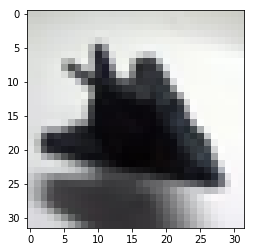

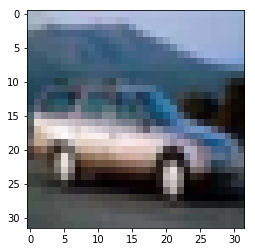

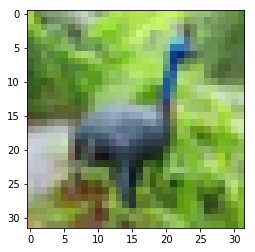

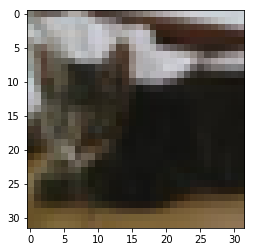

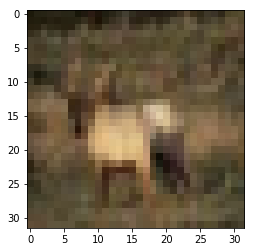

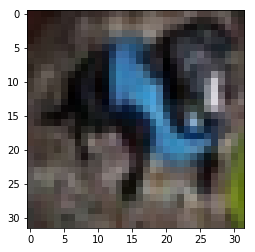

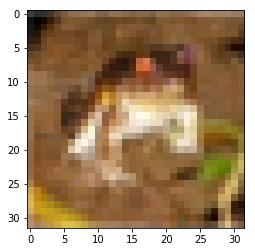

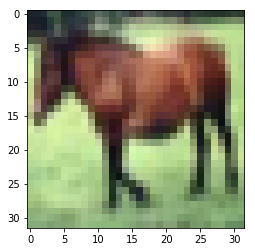

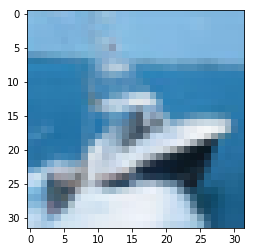

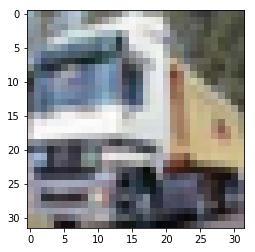

In [23]:
show_image_classes(x_train,y_train,prefix,"raw")

In [24]:
if treat_data == "normalize" : 
    x_train,x_test = normalize_data(x_train,x_test)

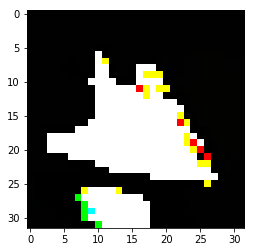

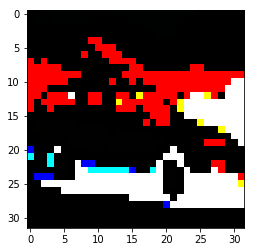

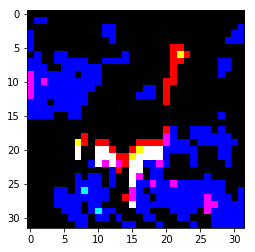

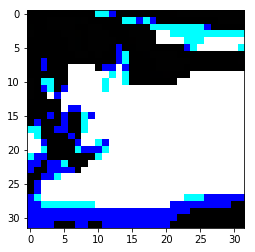

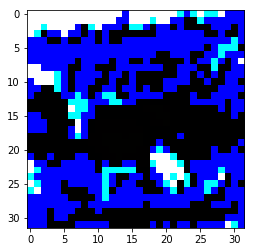

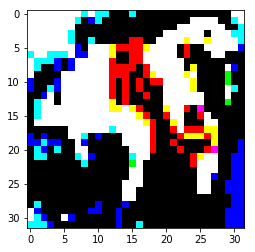

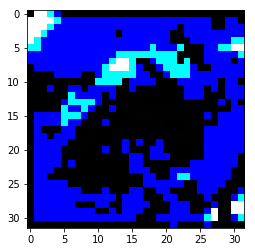

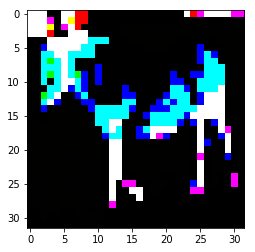

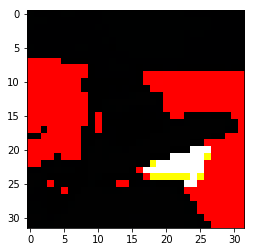

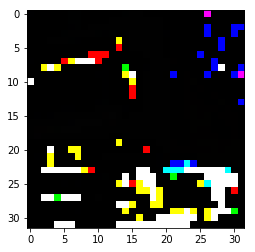

In [25]:
if treat_data == "normalize" : 
    show_image_classes(x_train,y_train,prefix,"normalised")

In [23]:
class_n_pos = [ind for ind,el in enumerate(y_train) if el == 30]

In [24]:
for img in class_n_pos:
    plt.figure()
    plt.imshow(np.uint8(x_train[img]))

In [25]:
len(class_n_pos)

0

In [26]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [27]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0.0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0)

In [28]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

In [29]:
models = []
model_names = []
input_shape = x_train[0].shape
batch_size=100
epochs = 80

In [30]:
models.append(create_MLP_1(input_shape))
model_names.append("MLP_Input_1")

In [31]:
models.append(create_MLP_2(input_shape))
model_names.append("MLP_Input_2")

/Users/jonathanjanke/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  
/Users/jonathanjanke/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/Users/jonathanjanke/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  del sys.path[0]


SimpleNet benchmark from https://github.com/EricAlcaide/SimpleNet-Keras/blob/master/simplenet.py

In [32]:
models.append(create_simple_net(input_shape))
model_names.append("Simple_Net")

In [33]:
history = []
lr = 0.0001
for model in models:
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=['accuracy'])

In [157]:
for model_ind, model in enumerate(models):  
  history.append(
      model.fit_generator(
          datagen.flow(x_train, y_train_categorical, batch_size=batch_size),
          steps_per_epoch = len(x_train)/batch_size,
          epochs=epochs,
          verbose=1,
          validation_data = (x_test, y_test_categorical)))
  model.save_weights(input_path + "Benchmark_Models/Data/" + prefix + "_" + model_names[model_ind] + ".h5")
  print ("Model success")

Epoch 1/80
500/500 [==============================] - 1274s 3s/step - loss: 1.5459 - acc: 0.4420 - val_loss: 1.2258 - val_acc: 0.5715
Epoch 2/80
500/500 [==============================] - 1231s 2s/step - loss: 1.1663 - acc: 0.5904 - val_loss: 1.0131 - val_acc: 0.6495
Epoch 3/80
500/500 [==============================] - 1231s 2s/step - loss: 1.0275 - acc: 0.6423 - val_loss: 0.9167 - val_acc: 0.6820
Epoch 4/80
500/500 [==============================] - 1234s 2s/step - loss: 0.9476 - acc: 0.6731 - val_loss: 0.8623 - val_acc: 0.7081
Epoch 5/80
500/500 [==============================] - 1232s 2s/step - loss: 0.8745 - acc: 0.6993 - val_loss: 0.8292 - val_acc: 0.7241
Epoch 6/80
500/500 [==============================] - 1223s 2s/step - loss: 0.8180 - acc: 0.7184 - val_loss: 0.7408 - val_acc: 0.7453
Epoch 7/80
500/500 [==============================] - 1233s 2s/step - loss: 0.7628 - acc: 0.7367 - val_loss: 0.7262 - val_acc: 0.7596
Epoch 8/80
500/500 [==============================] - 1233s 2s

Epoch 62/80
500/500 [==============================] - 1263s 3s/step - loss: 0.0654 - acc: 0.9777 - val_loss: 0.8608 - val_acc: 0.8439
Epoch 63/80
500/500 [==============================] - 1248s 2s/step - loss: 0.0585 - acc: 0.9806 - val_loss: 0.8526 - val_acc: 0.8440
Epoch 64/80
500/500 [==============================] - 1341s 3s/step - loss: 0.0592 - acc: 0.9808 - val_loss: 0.9287 - val_acc: 0.8461
Epoch 65/80
500/500 [==============================] - 1319s 3s/step - loss: 0.0601 - acc: 0.9804 - val_loss: 0.8093 - val_acc: 0.8455
Epoch 66/80
500/500 [==============================] - 1247s 2s/step - loss: 0.0563 - acc: 0.9813 - val_loss: 0.9179 - val_acc: 0.8474
Epoch 67/80
500/500 [==============================] - 1235s 2s/step - loss: 0.0560 - acc: 0.9820 - val_loss: 0.8044 - val_acc: 0.8441
Epoch 68/80
500/500 [==============================] - 1233s 2s/step - loss: 0.0557 - acc: 0.9821 - val_loss: 0.9185 - val_acc: 0.8448
Epoch 69/80
500/500 [==============================] - 

500/500 [==============================] - 153s 305ms/step - loss: 0.4514 - acc: 0.8417 - val_loss: 0.6031 - val_acc: 0.7951
Epoch 43/80
500/500 [==============================] - 152s 305ms/step - loss: 0.4408 - acc: 0.8448 - val_loss: 0.6001 - val_acc: 0.7949
Epoch 44/80
500/500 [==============================] - 152s 305ms/step - loss: 0.4292 - acc: 0.8487 - val_loss: 0.6015 - val_acc: 0.7964
Epoch 45/80
500/500 [==============================] - 153s 305ms/step - loss: 0.4254 - acc: 0.8501 - val_loss: 0.6082 - val_acc: 0.7936
Epoch 46/80
500/500 [==============================] - 153s 305ms/step - loss: 0.4192 - acc: 0.8513 - val_loss: 0.5997 - val_acc: 0.7972
Epoch 47/80
500/500 [==============================] - 153s 307ms/step - loss: 0.4131 - acc: 0.8525 - val_loss: 0.6094 - val_acc: 0.7964
Epoch 48/80
500/500 [==============================] - 153s 305ms/step - loss: 0.4044 - acc: 0.8569 - val_loss: 0.6043 - val_acc: 0.7994
Epoch 49/80
500/500 [==============================] 

In [158]:
for model in models:
  score = model.evaluate(x_test, y_test_categorical, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

Test loss: 0.847570672172308
Test accuracy: 0.8504
Test loss: 0.6201977861404419
Test accuracy: 0.8113
Test loss: 0.4729407775402069
Test accuracy: 0.8852


In [64]:
model = cifar100vgg(train=False)

NameError: name 'cifar100vgg' is not defined

In [62]:
model.model.count_params()

/Users/jonathanjanke/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/sequential.py:109: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


5497226

In [63]:
for model in models:
    print(model.count_params())

6684810
1250858
5497226


In [93]:
predicted_x = model.predict(x_test, normalize=False)
residuals = np.argmax(predicted_x,1)!=np.argmax(y_test_categorical,1)

loss = sum(residuals)/len(residuals)
print("the validation 0/1 loss is: ",loss)

the validation 0/1 loss is:  0.0641


In [38]:
models.append(keras.models.clone_model(model.model))
model_names.append("VGG_16")
models[0].set_weights(model.model.get_weights())

In [33]:
ann_viz(model.model, filename= input_path + "Benchmark_Models/Visualisations/" + prefix + "_" + "VGG" + ".gv",title="Visualisation of " + "VGG")

In [35]:
for i, model in enumerate(models):
    plot_model(model, input_path + "Benchmark_Models/Visualisations/" + prefix + "_" + model_names[i] + ".png", show_shapes=True)
    ann_viz(model, filename= input_path + "Benchmark_Models/Visualisations/" + prefix + "_" + model_names[i] + ".gv",title="Visualisation of " + model_names[i])

The following line will create the output file

In [39]:
# output_models = []
for model in models:
  cut_model(model)
  # output_models.append(out)

In [46]:
now = datetime.datetime.now()
prefix = now.strftime("%Y%m%d_%H%M")
create_output_files(x_train,x_test,y_train,y_test, prefix, suffix="_" + treat_data)

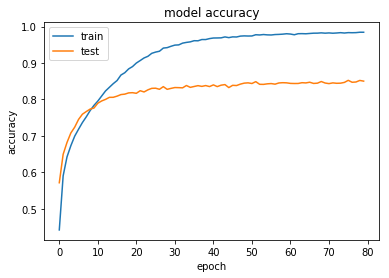

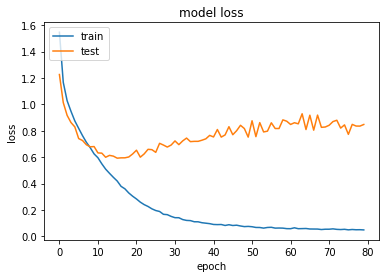

In [164]:
plot_model_stats(history[0])

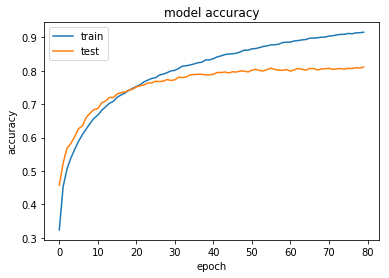

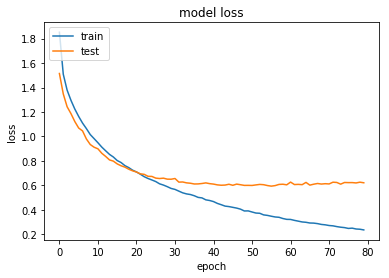

In [165]:
plot_model_stats(history[1])

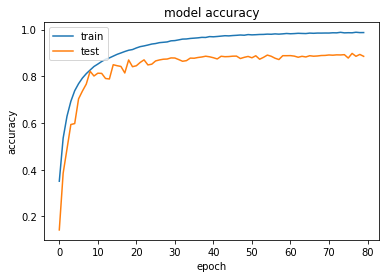

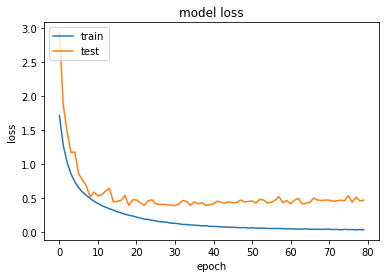

In [166]:
plot_model_stats(history[2])